In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [ ]:
!pip install itables

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.1 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt

import itables
from itables import show

In [2]:
path = 'data_eda.csv'
data = pd.read_csv(path
                   ).drop(columns=['Unnamed: 0', 'CC50, mM', 'SI'], axis=1
).rename(columns={'IC50, mM': 'IC50'})

In [3]:
show(data.corr()['IC50'])

In [ ]:
mean = data['IC50'].mean()
std = data['IC50'].std()
lower_bound = mean - 3 * std
upper_bound = mean + 3 * std

data["outlier"] = (data['IC50'] < lower_bound) | (data['IC50'] > upper_bound)
data[(data['IC50'] < lower_bound) | (data['IC50'] > upper_bound)]

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_piperzine,fr_priamide,fr_pyridine,fr_quatN,fr_sulfide,fr_thiazole,fr_thiophene,fr_unbrch_alkane,IC50,outlier
28,11.426207,0.078657,-0.901343,0.415354,10.733333,228.193,0.455184,-0.357600,1.600000,32.166426,...,0,0,0,0,1,0,0,0,1472.457163,True
29,11.443183,0.096481,-1.486768,0.498725,12.812500,244.192,0.455184,-0.357600,1.562500,32.197151,...,0,0,0,0,0,0,0,0,4095.188563,True
30,11.514537,0.089398,-0.894256,0.450486,10.812500,242.220,0.455184,-0.357600,1.625000,32.166553,...,0,0,0,0,1,0,0,0,4128.529377,True
31,11.531512,0.066530,-1.448188,0.541563,12.764706,258.219,0.455184,-0.357600,1.588235,32.197278,...,0,0,0,0,0,0,0,0,1936.355856,True
83,11.810278,0.006944,-0.006944,0.520631,46.818182,152.237,0.144110,-0.298479,1.363636,16.141544,...,0,0,0,0,0,0,0,0,2200.501846,True
94,11.573125,0.025463,0.025463,0.520631,46.818182,152.237,0.139099,-0.299064,1.363636,16.140190,...,0,0,0,0,0,0,0,0,1646.106754,True
95,11.810278,0.006944,-0.006944,0.520631,46.818182,152.237,0.144110,-0.298479,1.363636,16.141544,...,0,0,0,0,0,0,0,0,3284.331113,True
261,11.006567,0.139444,-0.139444,0.557758,19.083333,173.212,0.319632,-0.465027,1.500000,16.533541,...,0,0,0,0,0,0,0,0,1731.961620,True
262,10.775317,0.174167,-0.174167,0.508684,19.727273,159.185,0.319366,-0.468053,1.545455,16.524826,...,0,0,0,0,0,0,0,0,1884.576002,True
492,11.583239,0.126848,-4.881176,0.542097,14.357143,213.155,0.453781,-0.393615,1.500000,19.413293,...,0,0,0,0,0,0,0,0,1407.406712,True


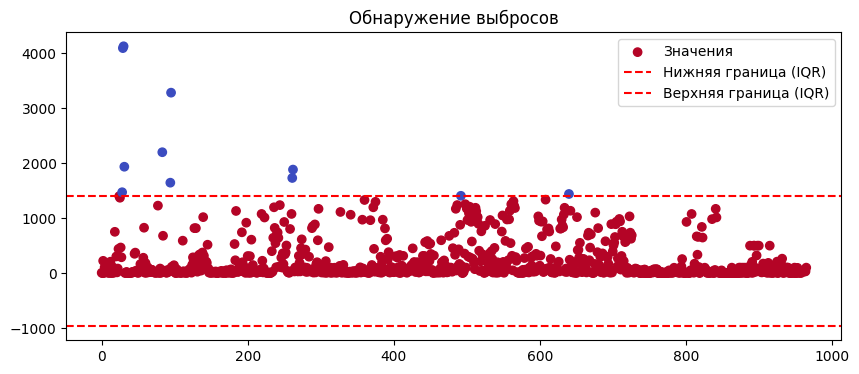

In [ ]:
plt.figure(figsize=(10, 4))
plt.scatter(data.index, data['IC50'], c=~data['outlier'], cmap='coolwarm', label='Значения')
plt.axhline(y=lower_bound, color='r', linestyle='--', label='Нижняя граница (IQR)')
plt.axhline(y=upper_bound, color='r', linestyle='--', label='Верхняя граница (IQR)')
plt.legend()
plt.title('Обнаружение выбросов')
plt.show()

In [ ]:
data['outlier_3'] = (data['IC50'] < lower_bound) | (data['IC50'] > upper_bound)
data_cleaned_IQR = data[~data['outlier_3']].drop(columns=['outlier', 'outlier_3'])

# Отбор признаков

In [ ]:
def correlation_feature_selections(df, target_col, threshold=0.1):
    # Оставляем только числовые признаки
    df_numeric = df.select_dtypes(include=[float, int])

    # Вычисляем корреляции с целевой переменной
    correlations = df_numeric.corr()[target_col].abs().sort_values(ascending=False)

    # Отбираем признаки с корреляцией выше порога
    selected_features = correlations[correlations > threshold].index.tolist()
    selected_features.remove(target_col)  # удаляем целевую переменную из признаков

    print(f"Выбранные признаки ({len(selected_features)}): {selected_features}")
    return selected_features

In [ ]:
selected_features_by_corr = correlation_feature_selections(data_cleaned_IQR, target_col='IC50')

Выбранные признаки (30): ['VSA_EState4', 'NumSaturatedHeterocycles', 'MinEStateIndex', 'EState_VSA8', 'PEOE_VSA7', 'SMR_VSA4', 'VSA_EState7', 'PEOE_VSA6', 'EState_VSA5', 'MolLogP', 'fr_C_S', 'MaxPartialCharge', 'qed', 'fr_NH2', 'FpDensityMorgan1', 'fr_Ndealkylation2', 'EState_VSA4', 'SMR_VSA5', 'NumAliphaticHeterocycles', 'PEOE_VSA4', 'BCUT2D_CHGLO', 'MaxAbsEStateIndex', 'BCUT2D_MWLOW', 'MolWt', 'fr_pyridine', 'fr_bicyclic', 'BalabanJ', 'fr_piperdine', 'fr_furan', 'fr_ester']


In [ ]:
def random_forest_feature_selection(df, target_col, n_top=40):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Разделение на трейн/тест
    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучаем модель
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Получаем важность признаков
    importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

    # Выводим топ-N самых важных
    top_features = importance.head(n_top).index.tolist()
    print(f"Топ-{n_top} важных признаков:\n", top_features)

    # График важности
    importance.nlargest(n_top).plot(kind='barh', figsize=(10, 8))
    plt.title("Feature Importance")
    plt.show()

    return top_features

Топ-20 важных признаков:
 ['VSA_EState4', 'BCUT2D_MRLOW', 'EState_VSA5', 'BCUT2D_MWLOW', 'Ipc', 'MolWt', 'FpDensityMorgan1', 'SPS', 'PEOE_VSA7', 'SlogP_VSA2', 'MolLogP', 'VSA_EState7', 'BCUT2D_CHGHI', 'qed', 'MinAbsEStateIndex', 'MinPartialCharge', 'BalabanJ', 'EState_VSA4', 'MaxPartialCharge', 'MinEStateIndex']


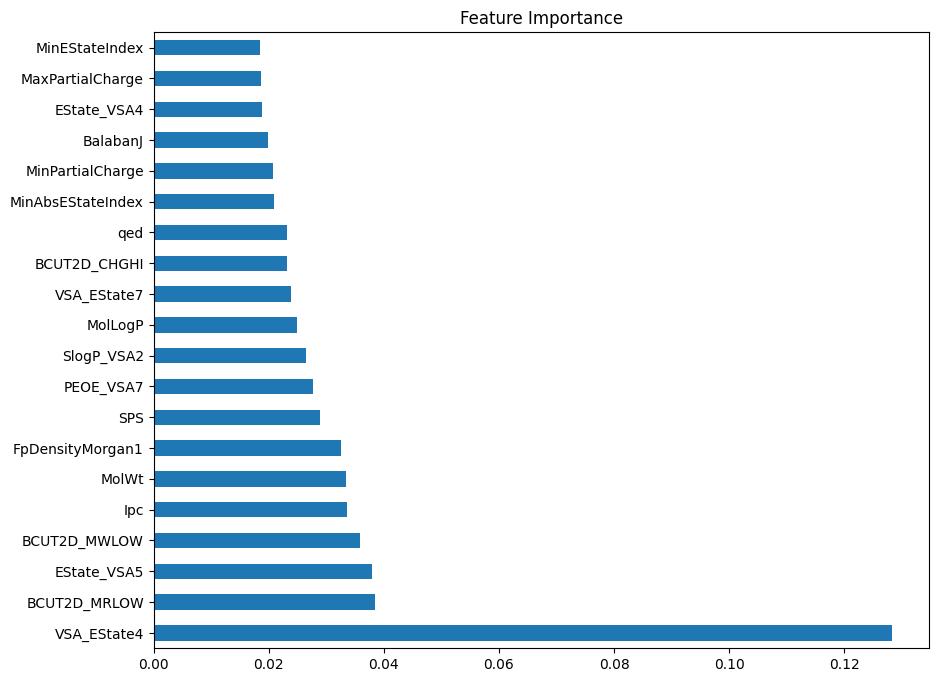

In [ ]:
selected_features_by_rand_for = random_forest_feature_selection(data_cleaned_IQR, target_col='IC50', n_top=20)

In [ ]:
def lasso_feature_selection(df, target_col):
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # Стандартизируем данные
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Подбор оптимального alpha и обучение Lasso
    model = LassoCV(cv=5, random_state=42, max_iter=10000)
    model.fit(X_scaled, y)

    # Определяем, какие признаки не занулены
    coef = pd.Series(model.coef_, index=X.columns)
    selected_features = coef[coef != 0].index.tolist()

    print(f"Коэффициенты:\n{coef.sort_values(ascending=False)}")
    print(f"Оставлено признаков: {len(selected_features)}")
    print("Оставленные признаки:", selected_features)

    return selected_features

In [ ]:
selected_features_by_lasso = lasso_feature_selection(data_cleaned_IQR, target_col='IC50')

Коэффициенты:
NumSaturatedHeterocycles    53.404739
fr_C_S                      27.130528
BCUT2D_CHGLO                26.721588
fr_pyridine                 14.144515
VSA_EState5                 11.252543
                              ...    
fr_ketone                  -20.926533
fr_priamide                -21.781413
SMR_VSA10                  -23.936193
fr_NH2                     -26.211323
MinEStateIndex             -39.871689
Length: 94, dtype: float64
Оставлено признаков: 32
Оставленные признаки: ['MinEStateIndex', 'MolWt', 'FpDensityMorgan1', 'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGLO', 'BalabanJ', 'PEOE_VSA6', 'SMR_VSA10', 'SMR_VSA4', 'EState_VSA4', 'EState_VSA5', 'EState_VSA7', 'EState_VSA8', 'VSA_EState4', 'VSA_EState5', 'NumAromaticHeterocycles', 'NumSaturatedHeterocycles', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_C_S', 'fr_NH1', 'fr_NH2', 'fr_Ndealkylation2', 'fr_epoxide', 'fr_ester', 'fr_furan', 'fr_ketone', 'fr_methoxy', 'fr_priamide', 'fr_pyridine', 'fr_sulfide']


# Подбор модели и гиперпарметров

In [ ]:
def get_models():
  models = {
      "Linear Regression": {
          "model": LinearRegression(),
          "params": {}
      },
      "Random Forest": {
          "model": RandomForestRegressor(random_state=42),
          "params": {
              'n_estimators': [20, 50, 100],
              'max_depth': [None, 5, 10, 20],
              'min_samples_split': [2, 3, 5, 10]
          }
      },
      "Gradient Boosting": {
          "model": GradientBoostingRegressor(random_state=42),
          "params": {
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5]
          }
      },
      "XGBoost": {
          "model": XGBRegressor(random_state=42, eval_metric='logloss'),
          "params": {
              'n_estimators': [50, 100],
              'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5]
          }
      },
      'CatBoost':{
          "model":  CatBoostRegressor(random_seed=42, verbose=0),
          "params": {
              'iterations': [100, 300],
              'learning_rate': [0.01, 0.05, 0.1],
              'depth': [4, 8],
              'l2_leaf_reg': [1, 5, 7]
          }
      }
  }

  return models

In [ ]:
def get_regression(X_train, y_train, X_test, y_test):
  results = []
  models = get_models()

  for model_name, config in models.items():
      print(f"\nОбучение модели: {model_name}")

      if not config['params']:  # пропускаем пустые параметры (например, у LinearRegression)
          model = config['model']
          model.fit(X_train, y_train)
          best_params = {}
      else:
          grid = GridSearchCV(config['model'], config['params'], cv=5, scoring='r2', n_jobs=-1)
          grid.fit(X_train, y_train)
          model = grid.best_estimator_
          best_params = grid.best_params_

      # Предсказание
      y_pred = model.predict(X_test)

      # Метрики
      mae = mean_absolute_error(y_test, y_pred)
      rmse = np.sqrt(mean_squared_error(y_test, y_pred))
      r2 = r2_score(y_test, y_pred)
      try:
          mape = mean_absolute_percentage_error(y_test, y_pred)
      except Exception as e:
          print(f"Ошибка при вычислении MAPE для {model_name}: {e}")
          mape = float('nan')

      results.append({
          "Model": model_name,
          "Best Params": best_params,
          "MAE": mae,
          "RMSE": rmse,
          "R²": r2
      })

      print(f"Лучшие параметры: {best_params}")
      print(f"MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}, MAPE: {mape:.2f}")
  return results

# Результаты

In [ ]:
X = data_cleaned_IQR[selected_features_by_corr]
y = data_cleaned_IQR['IC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

res1 = get_regression(X_train_scaled, y_train, X_test_scaled, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 212.3652, RMSE: 306.3251, R²: 0.1697, MAPE: 64.76

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
MAE: 210.5250, RMSE: 299.2494, R²: 0.2077, MAPE: 82.38

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 211.7451, RMSE: 312.0990, R²: 0.1381, MAPE: 76.34

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 207.6385, RMSE: 309.3003, R²: 0.1535, MAPE: 77.18

Обучение модели: CatBoost
Лучшие параметры: {'depth': 4, 'iterations': 100, 'l2_leaf_reg': 7, 'learning_rate': 0.1}
MAE: 200.8034, RMSE: 293.9288, R²: 0.2356, MAPE: 70.29


In [ ]:
X = data_cleaned_IQR[selected_features_by_lasso]
y = data_cleaned_IQR['IC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

res2 = get_regression(X_train_scaled, y_train, X_test_scaled, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 201.6430, RMSE: 294.4942, R²: 0.2326, MAPE: 52.32

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
MAE: 214.3026, RMSE: 298.6213, R²: 0.2110, MAPE: 84.25

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 215.7872, RMSE: 309.4109, R²: 0.1529, MAPE: 98.87

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 211.0101, RMSE: 310.4438, R²: 0.1473, MAPE: 108.98

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 100, 'l2_leaf_reg': 1, 'learning_rate': 0.05}
MAE: 188.5646, RMSE: 284.5875, R²: 0.2834, MAPE: 61.71


In [ ]:
X = data_cleaned_IQR[selected_features_by_rand_for]
y = data_cleaned_IQR['IC50']

# Разделение на трейн/тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

res3 = get_regression(X_train_scaled, y_train, X_test_scaled, y_test)


Обучение модели: Linear Regression
Лучшие параметры: {}
MAE: 226.6706, RMSE: 321.2889, R²: 0.0866, MAPE: 128.81

Обучение модели: Random Forest
Лучшие параметры: {'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 100}
MAE: 219.5996, RMSE: 304.2463, R²: 0.1810, MAPE: 97.92

Обучение модели: Gradient Boosting
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 221.4564, RMSE: 312.2427, R²: 0.1374, MAPE: 84.04

Обучение модели: XGBoost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MAE: 217.3866, RMSE: 323.4699, R²: 0.0742, MAPE: 77.28

Обучение модели: CatBoost
Лучшие параметры: {'depth': 8, 'iterations': 300, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
MAE: 201.2341, RMSE: 299.8483, R²: 0.2045, MAPE: 104.03
